<a href="https://colab.research.google.com/github/Followb1ind1y/D2L_Pytorch_Study_Notes/blob/main/03_D2L_Linear_Neural_Networks_for_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. Dive into Deep Learning Study Notes - Linear Neural Networks for Regression**

## **3.2. Object-Oriented Design for Implementation**

On a high level we wish to have three classes: (i) `Module` **contains models, losses, and optimization methods**; (ii) `DataModule` provides **data loaders** for training and validation; (iii) both classes are combined using the `Trainer` class, which allows us to **train models on a variety of hardware platforms**. 

In [60]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### **3.2.2. Models**

The **Module class** is the base class of all models we will implement. At a minimum we need to define three methods. The `__init__` method stores the **learnable parameters**, the `training_step` method **accepts a data batch to return the loss value**, the `configure_optimizers` method **returns the optimization method**, or a list of them, that is used to update the learnable parameters. Optionally we can define `validation_step` to **report the evaluation measure**s. Sometimes we put the code to compute the output into a separate forward method to make it more reusable.

In [61]:
class Module(nn.Module, d2l.HyperParameters):
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters() # NotImplemented
        self.board = ProgressBoard() # NotImplemented
        
    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

### **3.2.3. Data**

The **DataModule** class is the **base class for data**. Quite frequently the `__init__` method is used to **prepare the data**. This includes downloading and preprocessing if needed. The `train_dataloader` returns the data loader for the training dataset. A **data loader** is a (Python) generator that **yields a data batch each time it is used**. This batch is then fed into the `training_step` method of Module to compute the loss. There is an optional `val_dataloader` to return the **validation dataset loader**. It behaves in the same manner, except that it yields data batches for the `validation_step` method in Module.

In [62]:
class DataModule(d2l.HyperParameters):
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

### **3.2.4. Training**

The **Trainer class** trains the learnable parameters in the Module class with data specified in DataModule. The key method is `fit`, which accepts two arguments: `model`, an instance of `Module`, and `data`, an instance of `DataModule`. It then iterates over the entire dataset `max_epochs` times to **train the model**.

In [63]:
class Trainer(d2l.HyperParameters):
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

## **3.3. Synthetic Regression Data**

In [64]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### **3.3.1. Generating the Dataset**

The following code snippet generates 1000 examples with 2-dimensional features drawn from a standard normal distribution. The resulting design matrix $X$ belongs to $\mathrm{R}^{1000\times 2}$. We generate each label by applying a ground truth linear function, corrupted them via additive noise $\epsilon$, drawn independently and identically for each example:

$$y = Xw + b + \epsilon$$

For convenience we assume that $\epsilon$ is drawn from a normal distribution with mean $\mu=0$ and standard deviation $\sigma = 0.01$. Note that for object-oriented design we add the code to the `__init__` method of a subclass of `d2l.DataModule`.

In [65]:
class SyntheticRegressionData(d2l.DataModule):
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

We set the true parameters to $w = [2,3.4]^{T}$ and $b=4.2$.

In [66]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

Each row in features consists of a vector in $\mathrm{R}^{2}$ and each row in labels is a scalar.

In [67]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([0.8041, 0.7803]) 
label: tensor([3.1526])


### **3.3.2. Reading the Dataset**

Training machine learning models often requires **multiple passes over a dataset**, grabbing one minibatch of examples at a time. This data is then used to update the model. We implement the `get_dataloader` function, registering it as a method in the `SyntheticRegressionData` class via `add_to_class`. It takes **a batch size, a matrix of features, and a vector of labels**, and generates **minibatches** of size `batch_size`. As such, each minibatch consists of a tuple of features and labels.

In [68]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

In [69]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


While the iteration implemented above is good for didactic purposes, it is **inefficient** in ways that might get us in trouble on real problems. For example, it requires that we **load all the data in memory** and that we perform lots of random memory access. The built-in iterators implemented in a deep learning framework are considerably more efficient and they can deal with sources such as data stored in files, data received via a stream, and data generated or processed on the fly.

### **3.3.3. Concise Implementation of the Data Loader**

Rather than writing our own iterator, we can call the **existing API in a framework to load data**. As before, we need a dataset with features X and labels y. Beyond that, we set batch_size in the built-in data loader and let it take care of shuffling examples efficiently.

In [70]:
@d2l.add_to_class(d2l.DataModule)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [71]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


## **3.4. Linear Regression Implementation from Scratch**

We will implement the entire method from scratch, including (i) the **model**; (ii) the **loss function**; (iii) a **minibatch stochastic gradient descent optimizer**; and (iv) the **training function** that stitches all of these pieces together.

In [72]:
%matplotlib inline
import torch
from d2l import torch as d2l

### **3.4.1. Defining the Model**

Before we can begin optimizing our model’s parameters by minibatch SGD, we need to have some parameters in the first place. In the following we **initialize weights** by drawing random numbers from a normal distribution with mean 0 and a standard deviation of 0.01. The magic number 0.01 often works well in practice, but you can specify a different value through the argument sigma. Moreover we set the **bias** to 0.

In [73]:
class LinearRegressionScratch(d2l.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [74]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    """The linear regression model."""
    return torch.matmul(X, self.w) + self.b

### **3.4.2. Defining the Loss Function**

Since updating our model requires taking the **gradient of our loss function**, we ought to define the loss function first. Here we use the **squared loss function**. In the implementation, we need to transform the true value y into the predicted value’s shape y_hat. The result returned by the following function will also **have the same shape as y_hat**. We also return the **averaged loss value** among all examples in the minibatch.

In [75]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

### **3.4.3. Defining the Optimization Algorithm**

For minibatch SGD, at each step, using a **minibatch randomly drawn** from our dataset, we **estimate the gradient of the loss** with respect to the parameters. Next, we **update the parameters** in the direction that may **reduce the loss**. The following code applies the update, given a set of parameters, a learning rate `lr`. Since our loss is computed as an average over the minibatch, we don’t need to adjust the learning rate against the batch size.

In [76]:
class SGD(d2l.HyperParameters):
    def __init__(self, params, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

We next define the `configure_optimizers` method, which returns an instance of the `SGD` class.

In [77]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

### **3.4.4. Training**

In each **epoch**, we iterate through the entire training dataset, passing once through every example (assuming that the number of examples is divisible by the batch size). In each **iteration**, we **grab a minibatch** of training examples, and compute its loss through the model’s training_step method. Next, we **compute the gradients** with respect to each parameter. Finally, we will call the optimization algorithm to **update the model parameters**. In summary, we will execute the following loop:

* Initialize parameters $(w,b)$
* Repeat until done
    * Compute gradient $g ← ∂_{(w,b)}\frac{1}{|Β|}∑_i l(x^{(i)}, y^{(i)}, w, b)$
    * Update parameters $(w,b) ← (w,b)- ηg$

In [78]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

We train our model with the learning rate `lr=0.03` and set `max_epochs=3`. Note that in general, both the number of epochs and the learning rate are hyperparameters. In general, setting hyperparameters is tricky and we will **usually want to use a 3-way split**, one set for **training**, a second for **hyperparameter seclection**, and the third reserved for the **final evaluation**. 

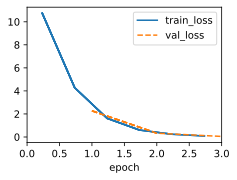

In [79]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [80]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1063, -0.1806], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.2428], grad_fn=<RsubBackward1>)


We should not take the ability to exactly recover the ground-truth parameters for granted. In general, for deep models unique solutions for the parameters **do not exist**, and even for linear models, exactly recovering the parameters is only possible when no feature is linearly dependent on the others. However, in machine learning, we are often **less concerned with recovering true underlying parameters**, and more concerned with **parameters that lead to highly accurate prediction**.

## **3.5. Concise Implementation of Linear Regression**

In [81]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### **3.5.1. Defining the Model**

For standard operations, we can use a framework’s predefined layers, which allow us to focus on the layers used to construct the model rather than worrying about their implementation. Recall the architecture of a single-layer network. The layer is called **fully connected**, since each of its **inputs is connected to each of its outputs by means of a matrix-vector multiplication**.

In PyTorch, the fully connected layer is defined in `Linear` and `LazyLinear` (available since version 1.8.0) classes. The latter allows users to only specify the output dimension, while the former additionally asks for how many inputs go into this layer. Specifying input shapes is inconvenient, which may require nontrivial calculations (such as in convolutional layers). Thus, for simplicity we will use such “lazy” layers whenever we can.

In [82]:
class LinearRegression(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [83]:
@d2l.add_to_class(LinearRegression)
def forward(self, X):
    """The linear regression model."""
    return self.net(X)

### **3.5.2. Defining the Loss Function**

The `MSELoss` class computes the **mean squared error** (without $\frac{1}{2}$ the factor). By default, `MSELoss` returns the average loss over examples. It is faster (and easier to use) than implementing our own.

In [84]:
@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

### **3.5.3. Defining the Optimization Algorithm**

Minibatch SGD is a standard tool for optimizing neural networks and thus PyTorch supports it alongside a number of variations on this algorithm in the optim module. When we instantiate an `SGD` instance, we specify the parameters to optimize over, obtainable from our model via `self.parameters()`, and the learning rate `(self.lr)` required by our optimization algorithm.

In [85]:
@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

### **3.5.4. Training**

Expressing our model through high-level APIs of a deep learning framework requires fewer lines of code. We did not have to allocate parameters individually, define our loss function, or implement minibatch SGD. Once we start working with much more complex models, the advantages of the high-level API will grow considerably. Now that we have all the basic pieces in place, the training loop itself is the same as the one we implemented from scratch.

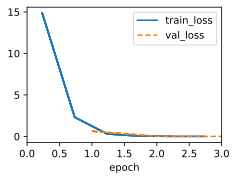

In [86]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [87]:
@d2l.add_to_class(LinearRegression)
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0007, -0.0105])
error in estimating b: tensor([0.0117])


## **3.6. Generalization**

The phenomenon of fitting closer to our training data than to the underlying distribution is called **overfitting**, and techniques for combatting overfitting are often called **regularization methods**.

### **3.6.1. Training Error and Generalization Error**
In the standard supervised learning setting,
we assume that the training data and the test data
are drawn *independently* from *identical* distributions.
This is commonly called the *IID assumption*.
Why should we believe that training data
sampled from distribution $P(X,Y)$
should tell us how to make predictions on
test data generated by a *different distribution* $Q(X,Y)$?
Making such leaps turns out to require
strong assumptions about how $P$ and $Q$ are related.
Later on we will discuss some assumptions
that allow for shifts in distribution
but first we need to understand the IID case,
where $P(\cdot) = Q(\cdot)$.

To begin with, we need to differentiate between
the *training error* $R_\text{emp}$,
which is a *statistic*
calculated on the training dataset,
and the *generalization error* $R$,
which is an *expectation* taken
with respect to the underlying distribution.
You can think of the generalization error as
what you would see  if you applied your model
to an infinite stream of additional data examples
drawn from the same underlying data distribution.
Formally the training error is expressed as a *sum* (with the same notation in :numref:`sec_linear_regression`):

$$R_\text{emp}[\mathbf{X}, \mathbf{y}, f] = \frac{1}{n} \sum_{i=1}^n l(\mathbf{x}^{(i)}, y^{(i)}, f(\mathbf{x}^{(i)})),$$


while the generalization error is expressed as an integral:

$$R[p, f] = E_{(\mathbf{x}, y) \sim P} [l(\mathbf{x}, y, f(\mathbf{x}))] =
\int \int l(\mathbf{x}, y, f(\mathbf{x})) p(\mathbf{x}, y) \;d\mathbf{x} dy.$$

Problematically, **we can never calculate
the generalization error $R$ exactly**.
Nobody ever tells us the precise form
of the density function $p(\mathbf{x}, y)$.
Moreover, we cannot sample an infinite stream of data points.
Thus, **in practice, we must *estimate* the generalization error
by applying our model to an independent test set**
constituted of a random selection of examples
$\mathbf{X}'$ and labels $\mathbf{y}'$
that were withheld from our training set.
This consists of applying the same formula
as for calculating the empirical training error
but to a test set $\mathbf{X}', \mathbf{y}'$.


Crucially, when we evaluate our classifier on the test set,
we are working with a *fixed* classifier
(it does not depend on the sample of the test set),
and thus estimating its error
is simply the problem of mean estimation.
However the same cannot be said
for the training set.
Note that the model we wind up with
depends explicitly on the selection of the training set
and thus the training error will in general
be a biased estimate of the true error
on the underlying population.
**The central question of generalization
is then when should we expect our training error
to be close to the population error
(and thus the generalization error)**.


We must stress another important point
that we will revisit when introducing deep neural networks.
When a model is capable of fitting arbitrary labels,
**low training error does not necessarily
imply low generalization error**.
*However, it does not necessarily
imply high generalization error either!*
All we can say confidently is that
low training error alone is not enough
to certify low generalization error.
Deep neural networks turn out to be just such models:
while they generalize well in practice,
they are too powerful to allow us to conclude
much on the basis of training error alone.
In these cases we must rely more heavily
on our holdout data to certify generalization
after the fact.
**Error on the holdout data**, i.e., **validation set**,
is called the *validation error*.

### **3.6.2. Underfitting or Overfitting**

When we compare the training and validation errors,
we want to be mindful of two common situations.
First, we want to watch out for cases
when our training error and validation error are both substantial
but there is a little gap between them.
**If the model is unable to reduce the training error,
that could mean that our model is too simple**
(i.e., insufficiently expressive)
to capture the pattern that we are trying to model.
Moreover, since the *generalization gap* ($R_\text{emp} - R$)
between our training and generalization errors is small,
**we have reason to believe that we could get away with a more complex model.
This phenomenon is known as *underfitting*.**

On the other hand, as we discussed above,
we want to watch out for the cases
**when our training error is significantly lower
than our validation error, indicating severe *overfitting*.**
Note that overfitting is not always a bad thing.
In deep learning especially,
the best predictive models often perform
far better on training data than on holdout data.
Ultimately, we usually care about
driving the generalization error lower,
and only care about the gap insofar
as it becomes an obstacle to that end.
Note that if the training error is zero,
then the generalization gap is precisely equal to the generalization error
and we can make progress only by reducing the gap.

Fixing our model, the **fewer samples** we have in the training dataset, the **more likely** (and more severely) we are to encounter **overfitting**. As we increase the amount of training data, the generalization error typically decreases. Moreover, in general, **more data never hurts**. For a fixed task and data distribution, model complexity should not increase more rapidly than the amount of data. Given more data, we might attempt to fit a more complex model. Absent sufficient data, simpler models may be more difficult to beat. For many tasks, deep learning only outperforms linear models when many thousands of training examples are available. In part, the current success of deep learning owes considerably to the abundance of massive datasets arising from Internet companies, cheap storage, connected devices, and the broad digitization of the economy.

### **3.6.3. Model Selection**

Typically, we select our final model, only after evaluating multiple models that differ in various ways (**different architectures, training objectives, selected features, data preprocessing, learning rates, etc.**). Choosing among many models is aptly called **model selection**.

In principle, **we should not touch our test set until after we have chosen all our hyperparameters**. Were we to use the test data in the model selection process, there is a risk that we might overfit the test data. Then we would be in serious trouble. If we overfit our training data, there is always the evaluation on test data to keep us honest.

Thus, **we should never rely on the test data for model selection**. And yet we cannot rely solely on the training data for model selection either because we cannot estimate the generalization error on the very data that we use to train the model.

The common practice to address the problem of training on the test set is to split our data three ways, incorporating a **validation set** in addition to the **training** and **test datasets**.

When training data is scarce,
we might not even be able to afford to hold out
enough data to constitute a proper validation set.
One popular solution to this problem is to employ
**$K$*-fold cross-validation*.**
Here, the original training data is split into $K$ non-overlapping subsets.
Then model training and validation are executed $K$ times,
each time training on **$K-1$ subsets** and validating
on **a different subset** (the one not used for training in that round).
Finally, the training and validation errors are estimated
by averaging over the results from the $K$ experiments.

## **3.7. Weight Decay**

### **3.7.1. Norms and Weight Decay**

(**Rather than directly manipulating the number of parameters,
*weight decay*, operates by restricting the values 
that the parameters can take.**)
More commonly called **$\ell_2$ regularization**
outside of deep learning circles
when optimized by minibatch stochastic gradient descent,
**weight decay** might be the most widely used technique
for regularizing parametric machine learning models.
The technique is motivated by the basic intuition
that among all functions $f$,
the function $f = 0$
(assigning the value $0$ to all inputs)
is in some sense the *simplest*,
and that **we can measure the complexity
of a function by the distance of its parameters from zero.**
But how precisely should we measure
the distance between a function and zero?
There's no single right answer.

One simple interpretation might be
to **measure the complexity of a linear function
$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$
by some norm of its weight vector**, e.g., $\| \mathbf{w} \|^2$.
Recall that we introduced the $\ell_2$ norm and $\ell_1$ norm,
which are special cases of the more general $\ell_p$ norm.
The most common method for ensuring a small weight vector
is to add its norm as a penalty term
to the problem of minimizing the loss.
Thus we replace our original objective,
*minimizing the prediction loss on the training labels*,
with new objective,
***minimizing the sum of the prediction loss and the penalty term*.**
Now, if our weight vector grows too large,
our learning algorithm might focus
on **minimizing the weight norm $\| \mathbf{w} \|^2$
vs. minimizing the training error.**
That is exactly what we want.
For linear regression.
There, our loss was given by

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Recall that $\mathbf{x}^{(i)}$ are the features,
$y^{(i)}$ is the label for any data example $i$, and $(\mathbf{w}, b)$
are the weight and bias parameters, respectively.
To penalize the size of the weight vector,
we must somehow add $\| \mathbf{w} \|^2$ to the loss function,
but how should the model trade off the
standard loss for this new additive penalty?
In practice, we characterize this tradeoff
via the *regularization constant* $\lambda$,
a non-negative hyperparameter
that we fit using validation data:

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2.$$

For $\lambda = 0$, we recover our original loss function.
For $\lambda > 0$, we restrict the size of $\| \mathbf{w} \|$.
We divide by $2$ by convention:
when we take the derivative of a quadratic function,
the $2$ and $1/2$ cancel out, ensuring that the expression
for the update looks nice and simple.

Moreover, you might ask why we work with the $\ell_2$ norm
in the first place and not, say, the $\ell_1$ norm.
In fact, other choices are valid and
popular throughout statistics.
While $\ell_2$-regularized linear models constitute
the classic ***ridge regression*** algorithm,
**$\ell_1$-regularized linear regression**
is a similarly fundamental method in statistics, 
popularly known as *lasso regression*.
One reason to work with the $\ell_2$ norm
is that **it places an outsize penalty
on large components of the weight vector.**
This biases our learning algorithm
towards models that distribute weight evenly
across a larger number of features.
In practice, this might make them more robust
to measurement error in a single variable.
By contrast, **$\ell_1$ penalties lead to models
that concentrate weights on a small set of features
by clearing the other weights to zero.**
This gives us an effective method for *feature selection*,
which may be desirable for other reasons.
For example, if our model only relies on a few features,
then we may not need to collect, store, or transmit data
for the other (dropped) features. 

The minibatch stochastic gradient descent updates
for $\ell_2$-regularized regression follow:

$$\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}$$

As before, we update $\mathbf{w}$ based on the amount
by which our estimate differs from the observation.
However, we also shrink the size of $\mathbf{w}$ towards zero.
That is why the method is sometimes called "weight decay":
given the penalty term alone,
our optimization algorithm *decays*
the weight at each step of training.
In contrast to feature selection,
weight decay offers us a continuous mechanism
for adjusting the complexity of a function.
Smaller values of $\lambda$ correspond
to less constrained $\mathbf{w}$,
whereas larger values of $\lambda$
constrain $\mathbf{w}$ more considerably.
Whether we include a corresponding bias penalty $b^2$ 
can vary across implementations, 
and may vary across layers of a neural network.
Often, we do not regularize the bias term.
Besides,
although $\ell_2$ regularization may not be equivalent to weight decay for other optimization algorithms,
the idea of regularization through
shrinking the size of weights
still holds true.

### **3.7.2. High-Dimensional Linear Regression**

In [88]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

First, we generate some data as before:

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$

In this synthetic dataset, our label is given 
by an underlying linear function of our inputs,
corrupted by Gaussian noise 
with zero mean and standard deviation 0.01.
For illustrative purposes, 
we can make the effects of overfitting pronounced,
by increasing the dimensionality of our problem to $d = 200$
and working with a small training set with only 20 examples.


In [89]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

### **3.7.3. Implementation from Scratch**

In [90]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [91]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [92]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

We now run this code with `lambd = 0`, disabling weight decay. Note that we overfit badly, decreasing the training error but not the validation error—a textbook case of overfitting.

L2 norm of w: 0.010072285309433937


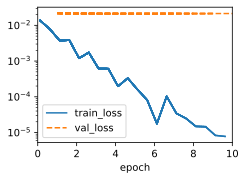

In [93]:
train_scratch(0)

Below, we run with substantial weight decay. Note that the training error increases but the validation error decreases. This is precisely the effect we expect from regularization.

L2 norm of w: 0.0014219747390598059


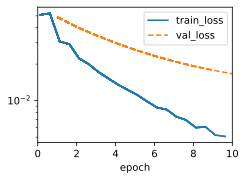

In [94]:
train_scratch(3)

### **3.7.4. Concise Implementation**

In the following code, we specify the weight decay hyperparameter directly through `weight_decay` when instantiating our optimizer. By default, PyTorch decays both weights and biases simultaneously, but we can configure the optimizer to handle different parameters according to different policies. Here, we only set `weight_decay` for the weights (the `net.weight` parameters), hence the bias (the `net.bias` parameter) will not decay.

In [95]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.014115428552031517


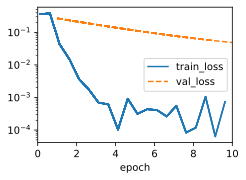

In [96]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

In [97]:
%%shell
jupyter nbconvert --to html 03_D2L_Linear_Neural_Networks_for_Regression.ipynb

[NbConvertApp] Converting notebook 03_D2L_Linear_Neural_Networks_for_Regression.ipynb to html
[NbConvertApp] Writing 569113 bytes to 03_D2L_Linear_Neural_Networks_for_Regression.html
